### Importing Packages and data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



In [2]:
#import sqlite3
#import pandas as pd  
dat = sqlite3.connect('database.sqlite') #connected to database

query = dat.execute("SELECT * From tweets")

cols = [column[0] for column in query.description]
results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
results.shape

(14485, 15)

In [ ]:
results.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


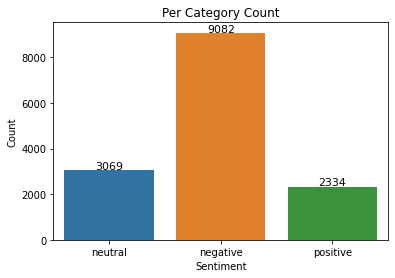

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.countplot(x='airline_sentiment',data=results)
plt.title('Per Category Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
for p in ax.patches:
             ax.annotate( p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 4),
                 textcoords='offset points')



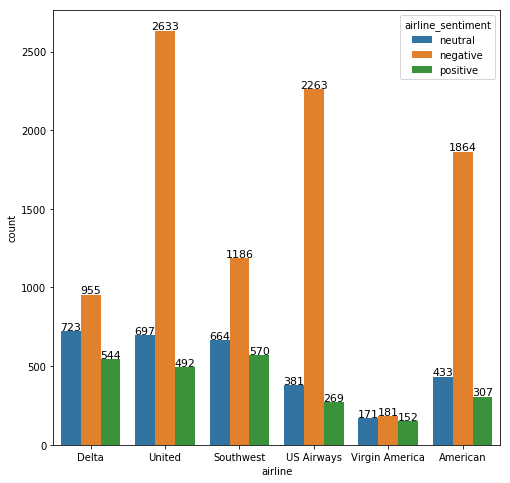

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='airline',hue='airline_sentiment',data=results)
for p in ax.patches:
             ax.annotate( p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 4),
                 textcoords='offset points')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

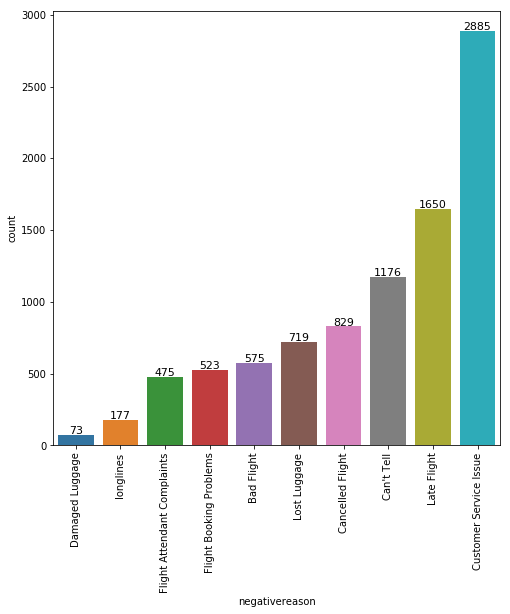

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='negativereason',data=results,order=results['negativereason'].value_counts().sort_values().index[:-1])
for p in ax.patches:
             ax.annotate( p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 4),
                 textcoords='offset points')
plt.xticks(rotation=90)

(-0.5, 1599.5, 799.5, -0.5)

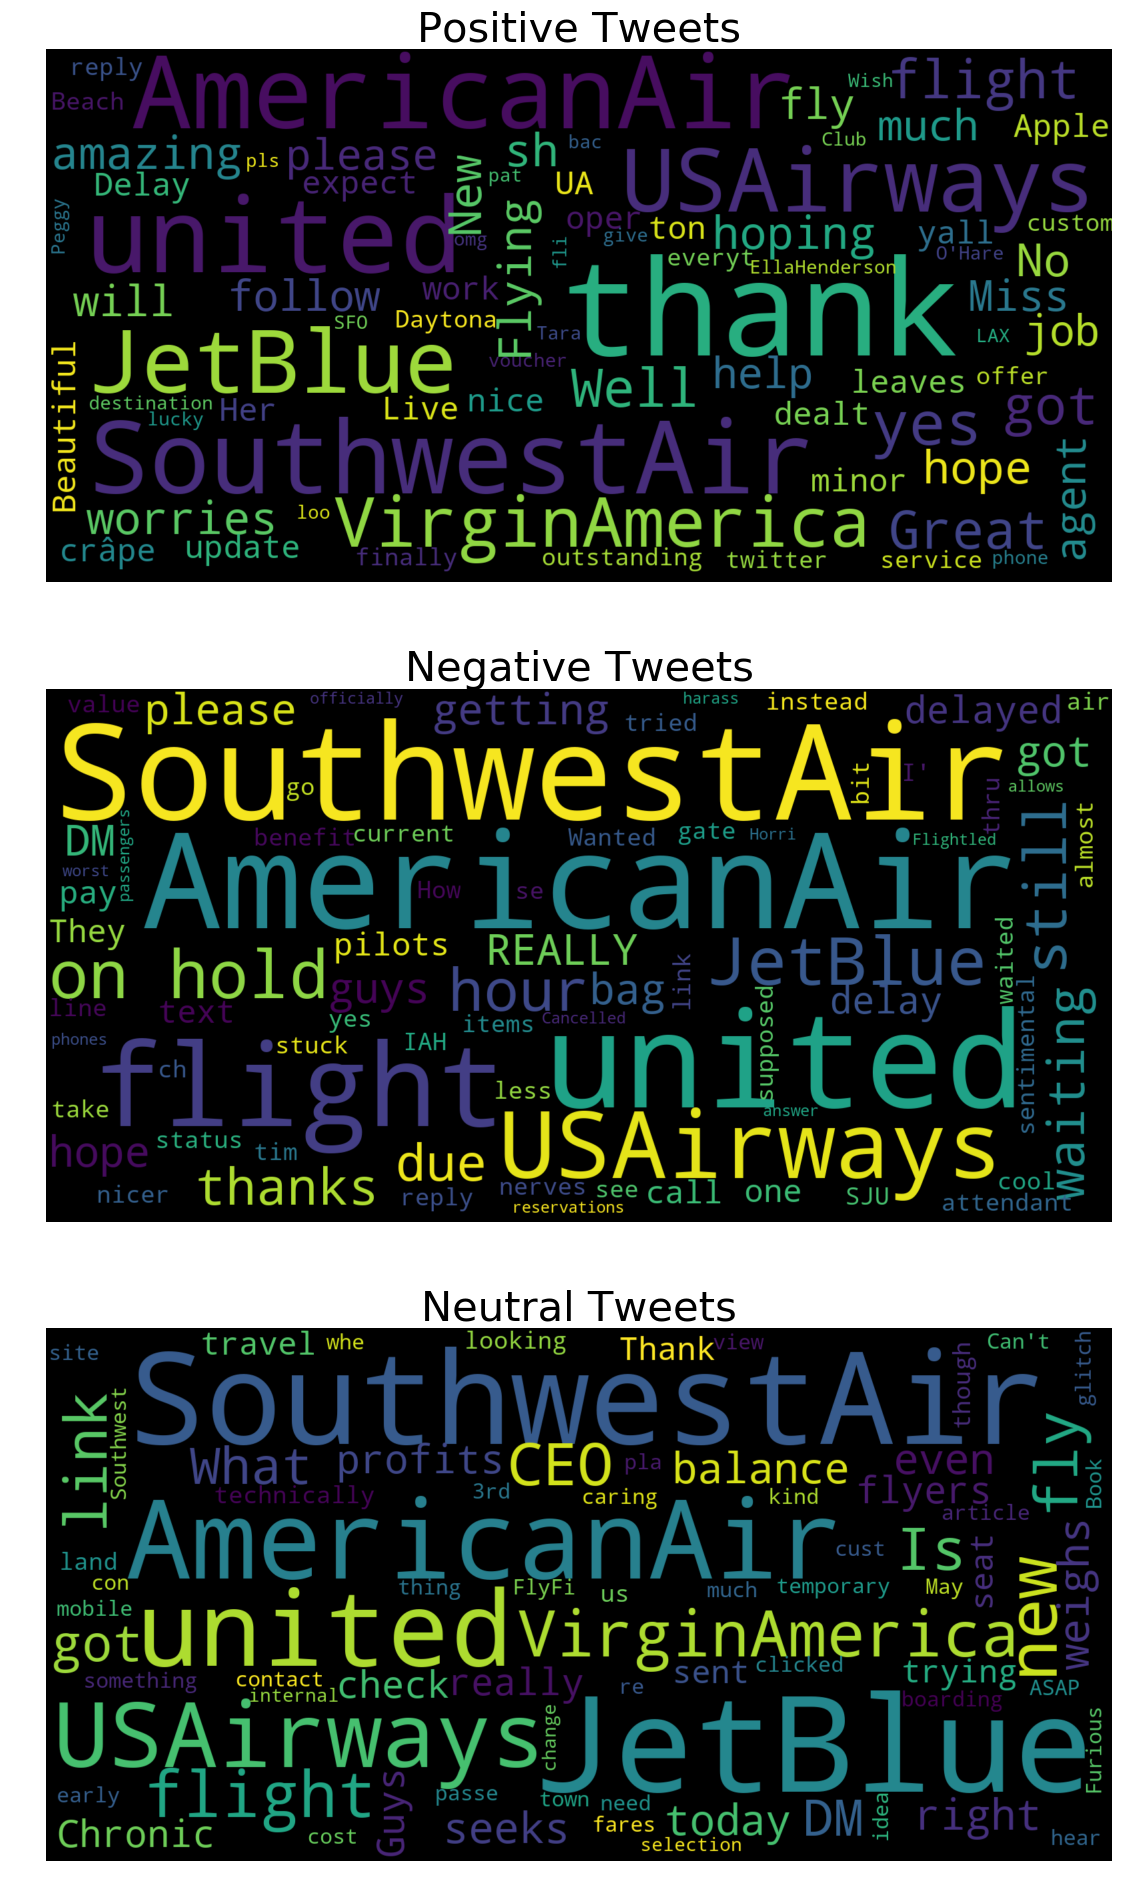

In [ ]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
stopwords = set(STOPWORDS)

positive_tweets = results[results['airline_sentiment']=='positive']
negative_tweets = results[results['airline_sentiment']=='negative']
neutral_tweets = results[results['airline_sentiment']=='neutral']

fig, ax = plt.subplots(3, 1, figsize  = (24,24),dpi=100)
wordcloud_positive = WordCloud(max_font_size=50, stopwords=stopwords, max_words=75, background_color="black",scale=4).generate(str(positive_tweets['text']))
wordcloud_negative = WordCloud(max_font_size=50, stopwords=stopwords, max_words=75, background_color="black",scale=4).generate(str(negative_tweets['text']))
wordcloud_neutral = WordCloud(max_font_size=50, stopwords=stopwords, max_words=75, background_color="black",scale=4).generate(str(neutral_tweets['text']))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Positive Tweets', fontsize=30)
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Negative Tweets', fontsize=30)
ax[1].axis('off')

ax[2].imshow(wordcloud_neutral, interpolation='bilinear')
ax[2].set_title('Neutral Tweets', fontsize=30)
ax[2].axis('off')

#plt.tight_layout(pad=0)

### Cleaning and Preparing Data

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


def clean_sentences(sentence):
    sentence = sentence.lower()
    sentence = re.sub('\d+','',sentence) #remove digits
    sentence = re.sub(r'@\w+\'?\w+', '',sentence)  #remove any account mentions
    sentence = re.sub(r'http\S+', '',sentence) #remove links
    sentence = re.sub(r"[^A-Za-z0-9']+", ' ',sentence) #remove special characters
    sentence = re.sub(r'\s+', ' ',sentence) #remove white spaces
    sentence = sentence.strip() #strip leading and trailing spaces
    sentence = ' '.join(i for i in sentence.split() if i not in stop_words) #remove stop words 
    sentence = ' '.join(wordnet_lemmatizer.lemmatize(i) for i in sentence.split()) #lemmatize words
    return sentence

results['cleaned_text'] = results['text'].apply(clean_sentences)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Need to split dataset into test, train,val before implementing TF-IDF

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
results['score_value'] = results['airline_sentiment'].apply(
      lambda x: 2 if x == 'positive' else (0 if x == 'negative' else 1)) #to get labels for logistic regression or 
                                                                         #conventioanl ML methods, apart from neural networks

X = results['cleaned_text'].values
y = pd.get_dummies(results['airline_sentiment']).values    #labels for deep learning methods
#y = results['score_value']                                 #label for conventional ML methods

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)
#X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5)

In [10]:
X_train

array(['wifi plane gotta pay help broke homegirl',
       "i've never treated badly",
       "need learn operation sit plane overnight gsp realize there's mech problem delay flight hour",
       ..., 'else would know denied',
       'calling hr getting told call back automated system extremely frustrating',
       'yr site trouble mobile check'], dtype=object)

### Using TfidfVectorizer to convert text into numeric form

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features=5000
vectorizer = TfidfVectorizer(max_features=5000,sublinear_tf=True,ngram_range=(1, 3),
                             encoding='utf-8',decode_error='ignore')


vectorizer.fit(X_train)
X_train=vectorizer.transform(X_train).toarray()
X_test=vectorizer.transform(X_test).toarray()
#X_validate = vectorizer.transform(X_validate).toarray()

In [7]:
#from IPython.display import Image
#Image(filename='image.jpg')
X_train.shape,X_test.shape

((12312, 5000), (2173, 5000))

### Using Tokenizer to convert text into numeric form

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=4000, split=" ")
tokenizer.fit_on_texts(X_train)

maxlen = 30
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen=maxlen) # padding our text vector so they all have the same length


X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test,maxlen=maxlen)

'''X_validate = tokenizer.texts_to_sequences(X_validate)
X_validate = pad_sequences(X_validate,maxlen=maxlen)'''

X_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  200,   12, 1165,  184,   10,  994],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   56,   58,  676, 1631],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   16,  756, 1318,  360,   12,  659,
        3500, 1166,  404, 1632,   59,   31,    1,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   64,   41,  234,
         757,  571,  882,   99,  572,   25,    1, 1910],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  319, 

In [ ]:
X_train.shape, X_test.shape, X_validate.shape

((10139, 100), (2173, 100), (2173, 100))

### Creating Model

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

model1 = Sequential()
model1.add(Embedding(5000, 15))
model1.add(LSTM(20,dropout=0.5))
model1.add(Dense(3,activation='softmax'))
model1.summary()


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test)) #,callbacks=[checkpoint1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 15)          75000     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               147456    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 223,227
Trainable params: 223,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
  3/385 [..............................] - ETA: 2:34:54 - loss: 1.0661 - accuracy: 0.4479

KeyboardInterrupt: ignored

In [23]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 128
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(X_test,y_test))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
97/97 [==============================] - 23s 236ms/step - loss: 0.7499 - accuracy: 0.6843 - val_loss

KeyboardInterrupt: ignored